# Analisis de comportamiento de uso de bicicletas compartido en la ciudad de los Ángeles.

##  Introducción al análisis exploratorio de datos
La ciudad de los Ángeles cuenta con un servicio de  bicicletas compartidas, donde los posibles clientes pueden recoger bicicletas en estaciones designadas y dejarlas en la misma estación o en una estación diferente. También hay diferentes tipos de pases disponibles para satisfacer las necesidades de los distintos tipos de clientes.

Como empresa líder en el servicio de compartimiento de bicicletas, se tiene como meta contar con la disponibilidad más alta de servicio en el mercado. 
Debido a una constante saturación del servicio se pueden estar perdiendo clientes, por falta de disponibilidad, y con la intuición de que la tendencia de uso va a la alza, la empresa debe estar preparada para ajustar el número de bicicletas según la demanda para seguir manteniendo el liderazgo en el mercado.

__La finalidad del siguiente análisis es:__
- Entender el comportamiento de uso de los usuarios por estaciones y horarios, dependiendo el plan de pago al que están sujetos.
- Confirmar que la tendencia en el uso compartido de bicicletas entre estaciones va en incremento.

__Esto ayudará a :__

- Identificar donde se deben instalar más bicicletas
- Confirmar que los planes anuales crezerán en mayor proporción.




## Diccionario de datos
__características__
- trip_id: identificador único para el viaje
- duration: duración del viaje en minutos
- start_time: dia/hora donde en viaje inicia en formato ISO 8601 tiempo local
- end_time: dia/hora donde el viaje termina en formato ISO 8601 tiempo local
- start_station: la estación donde el viaje inició
- start_lat: la latitud de la estación donde el viaje se originó
- start_lon: la longitud de la estación donde el viaje se originó
- end_station: la estación donde el viaje terminó
- end_lat: la latitud de la estación donde terminó el viaje
- end_lon: la longitud de la estación donde terminó el viaje
- bike_id: un entero único que identifica la bicicleta
- trip_route_category: “Round trip” son viajes que empiezan y terminan en la misma estación

__objetivo__
- plan_duration: número de días que el usuario tendrá el paso. 0 significa un viaje único (Walk-up plan)
- passholder_type: El nombre del plan de passholder

## Set up de datos
Se descargan las librerias correspondientes y se guarda el data frame para analizar los datos con los que se va a trabajar y entenderlos

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from scipy import stats as st
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , mean_squared_error,confusion_matrix ,accuracy_score , f1_score, precision_score, recall_score ,roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.utils import shuffle



Se cargan los diferentes df para entrenar al modelo y probarlo con los diferentes datasets.

In [2]:
df_train = pd.read_csv('Desktop/Prueba_DS_Arkon/train_set.csv',low_memory=False)
df_test = pd.read_csv('Desktop/Prueba_DS_Arkon/test_set.csv',low_memory=False)


Se analiza el df de prueba junto con sus caracteristicas y estadisticas para tener una imagen de los datos.
1. Se despliega un sample de todo el df para ver que datos tiene y como lucen
2. Se despliega la cantidad de columnas con sus nombres, tipo de dato y si tienen valores nulos.
3. Se despliega indicadores estadisticos de las caracteristicas numéricas, para ver si a primer vista se pueden ver outliers y entender un poco mas los datos.

In [3]:
display(df_train.head())
display(df_train.info())
print(df_train.describe())

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


None

            trip_id       duration      start_lat      start_lon  \
count  7.000000e+05  700000.000000  694437.000000  694437.000000   
mean   1.069468e+08      37.084979      34.044952    -118.253849   
std    4.497342e+07     125.302510       0.325255       2.332640   
min    8.369648e+06       1.000000      33.710979    -118.495422   
25%    7.538051e+07       7.000000      34.037460    -118.280952   
50%    1.179410e+08      13.000000      34.046612    -118.256980   
75%    1.404178e+08      26.000000      34.051941    -118.247162   
max    1.794831e+08    1440.000000      55.705528     118.238258   

             end_lat        end_lon  plan_duration  start_station  \
count  681426.000000  681426.000000  699792.000000  700000.000000   
mean       34.044175    -118.259183      44.928697    3499.720464   
std         0.299721       2.129781      92.816296     615.918795   
min        33.710979    -118.495422       0.000000    3000.000000   
25%        34.037048    -118.280952       

In [4]:
df_train.isnull().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5563
start_lon               5563
end_lat                18574
end_lon                18574
bike_id                    0
plan_duration            208
trip_route_category        0
passholder_type         2576
start_station              0
end_station                0
dtype: int64

__Se encuentra lo siguiente:__
- start_lat , start_lon  , end_lat y end_lon tienen valores nulos            
- plan_duration y passholder_type tienen valores nulos.
- start_time y end_time no estan formato de date
- el plan_duration cuenta con un max de 999, lo cual es un valor fuera de lo común

Por lo que se analizarán mas a profundidad y corregiran de ser necesario

Ya que las caracteristicas con longitudes y latitudes son las que contienen valores nulos, y ademas tienen su equivalencia en el start_station y end_station se procede a eliminarlas.

In [5]:
df_train = df_train.drop(['start_lat', 'start_lon', 'end_lat', 'end_lon'], axis=1)
df_test = df_test.drop(['start_lat', 'start_lon', 'end_lat', 'end_lon'], axis=1)

Se confirma que las caracteristicas se hayan eliminado correctamente.

In [6]:
df_train.isnull().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
bike_id                   0
plan_duration           208
trip_route_category       0
passholder_type        2576
start_station             0
end_station               0
dtype: int64

Aún se tienen valores nulos en plan_duration y passholder_type por lo que se analizan cuantos valores unicos tienen las caracteristicas plan_duration y passholder_type, para entender un poco mas su contenido.

In [7]:
df_train['passholder_type'].unique()

array(['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass',
       'Flex Pass', nan, 'Testing'], dtype=object)

Se identifica que en passholder_type hay un campo de testing por lo que se procede a eliminar, ya que esta informacion contiene dummys que pueden afectar nuestro modelado.

In [8]:
df_train = df_train[df_train['passholder_type'] != 'Testing']
df_train['passholder_type'].unique()


array(['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass',
       'Flex Pass', nan], dtype=object)

Se confirma que el valor de Testing se ha eliminado correctamente y se ve que aun hay un passholder_type con valor nan, el cual  se revisa para tener mas contexto

In [9]:
df_nan_passholder = df_train[df_train['passholder_type'].isna()]
df_nan_passholder['plan_duration'].unique()

array([30.])

Se verifica que el passholder_type con nan tiene un plan_duration solo de 30 por lo que se restablece el valor nan por Monthly Pass.

In [10]:
df_train.loc[df_train['passholder_type'].isna(), 'passholder_type'] = 'Monthly Pass'
df_train['passholder_type'].unique()

array(['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass',
       'Flex Pass'], dtype=object)

Nos hemos quedado solo con pases reales, ahora se revisara el plan duration.

In [11]:
df_train['plan_duration'].unique()


array([  1.,   0.,  30., 365.,  nan, 150.])

Hay planes con duración nan, por lo que ahora se hace el chequeo a la inversa para saber a que passholders pertenecen, inferir su valor y restablecerlo.

In [12]:
df_nan_pduration = df_train[df_train['plan_duration'].isna()]
df_nan_pduration['passholder_type'].unique()

array(['Monthly Pass'], dtype=object)

Ya que los nan solo pertenecen al Monthly Pass, se restablecera el valor a 30.

In [13]:
df_train.loc[df_train['plan_duration'].isna(), 'plan_duration'] = 30
df_train['plan_duration'].unique()

array([  1.,   0.,  30., 365., 150.])

Ahora se procede a pasar los datos de start_time y end_ time a formato de date.

In [14]:
df_train['start_time'] = pd.to_datetime(df_train['start_time'])
df_train['end_time'] = pd.to_datetime(df_train['end_time'])


Se confirma que el data set, ya no contiene valores nulos, los tipos de datos son los correctos, y se han descartado las características innecesarias.

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699922 entries, 0 to 699999
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_id              699922 non-null  int64         
 1   duration             699922 non-null  int64         
 2   start_time           699922 non-null  datetime64[ns]
 3   end_time             699922 non-null  datetime64[ns]
 4   bike_id              699922 non-null  object        
 5   plan_duration        699922 non-null  float64       
 6   trip_route_category  699922 non-null  object        
 7   passholder_type      699922 non-null  object        
 8   start_station        699922 non-null  int64         
 9   end_station          699922 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 58.7+ MB


## Análisis exploratorio de Datos (EDA)
Se procede a analizar los datos una vez limpios y estandarizados para entender el comportamiento de los usuarios, por estacion, horario y plan.

In [16]:
def count_plot(value):
    sns.countplot(x=value, data=df_train)


Text(0.5, 1.0, 'Distribución de tipos de Viaje')

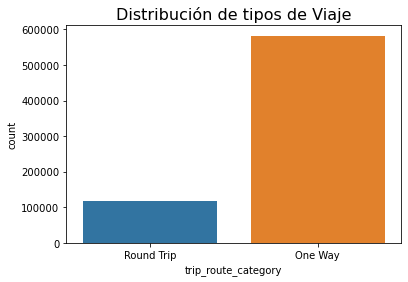

In [17]:
count_plot('trip_route_category')
plt.title('Distribución de tipos de Viaje', fontsize=16)

In [18]:
total_routes = df_train['trip_route_category'].count()
one_way = len(df_train.loc[(df_train['trip_route_category'] == 'One Way')])
round_trip = len(df_train.loc[(df_train['trip_route_category'] == 'Round Trip')])
print("Porcentaje de viajes redondos: {}%".format(round(round_trip / total_routes * 100, 2)))

Porcentaje de viajes redondos: 16.84%


Se dividen todos los viajes por tipo de viaje, y se puede ver que la __83.2% de viajes son de un sentido __, lo que indica que los usuarios toman las bicicletas en una estacion y la dejan en otra.

Text(0.5, 1.0, 'Distribución tipos de pases vs tipo de viaje')

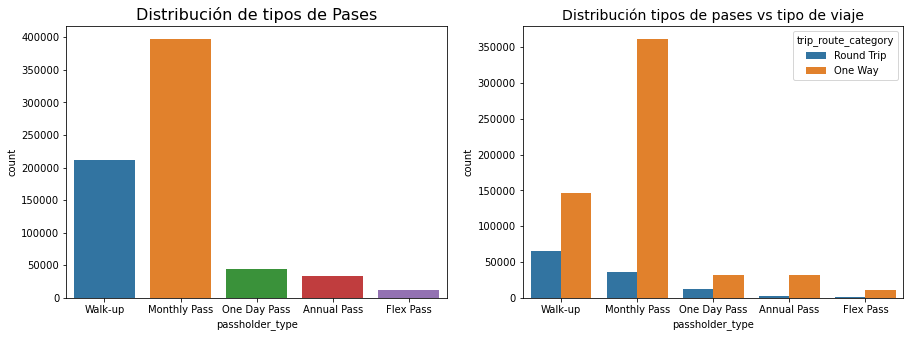

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
count_plot('passholder_type')
plt.title('Distribución de tipos de Pases', fontsize=16)
plt.subplot(1, 2, 2)
sns.countplot(x='passholder_type', data=df_train, hue='trip_route_category')
plt.title('Distribución tipos de pases vs tipo de viaje', fontsize=14)

In [20]:
value_counts = df_train['passholder_type'].value_counts()
value_perc = (value_counts / value_counts.sum()) * 100
display(value_perc)

Monthly Pass    56.769897
Walk-up         30.349953
One Day Pass     6.351422
Annual Pass      4.870828
Flex Pass        1.657899
Name: passholder_type, dtype: float64

__Se revisa la distribucion de los viajes por tipo de pase y tipo de viaje.__
- El 56.7% esta compuesto por Monthly Pass, mientras que solo el 4.8% usan un Annual Pass.
- En todos los tipos de pases la mayoria de viajes son de un solo sentido.

In [21]:
# hacer un breakdown con los que tenmas mas de 11mil viajes

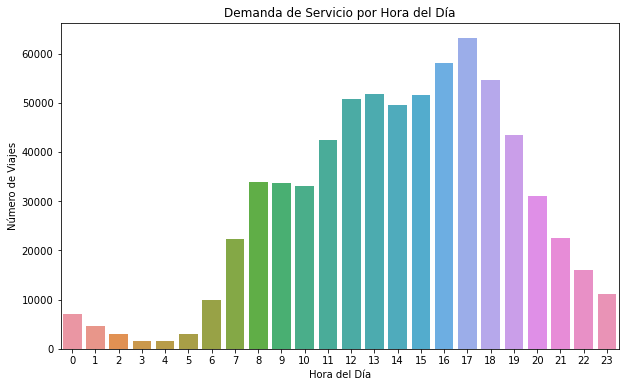

In [22]:
df_train['hour'] = df_train['start_time'].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x='hour', data=df_train)
plt.title('Demanda de Servicio por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Viajes')
plt.show()

In [23]:
hourly_demand_by_pass = df_train.groupby(['hour', 'passholder_type']).size().reset_index(name='num_trips')

mean_trips_by_hour_and_pass = hourly_demand_by_pass.groupby(['hour'])['num_trips'].mean().reset_index(name='mean_num_trips')

In [24]:
top_7_hours = mean_trips_by_hour_and_pass.sort_values(by='mean_num_trips', ascending=False).head(7)
display(top_7_hours)

,hour,mean_num_trips
17,17,12623.2
16,16,11609.2
18,18,10940.6
13,13,10366.2
15,15,10323.4
12,12,10149.2
14,14,9907.4


Se revisan la distribucion de uso por hora del día.Además de sacar la media de los viajes por hora.

__Se encuentra que:__
- Hora pico de demanda 17hrs
- Rango de alto consumo de las 12 a las 18hr
- En las horas picos suele habe un consumo de arriba de 10 mil viajes por hora.

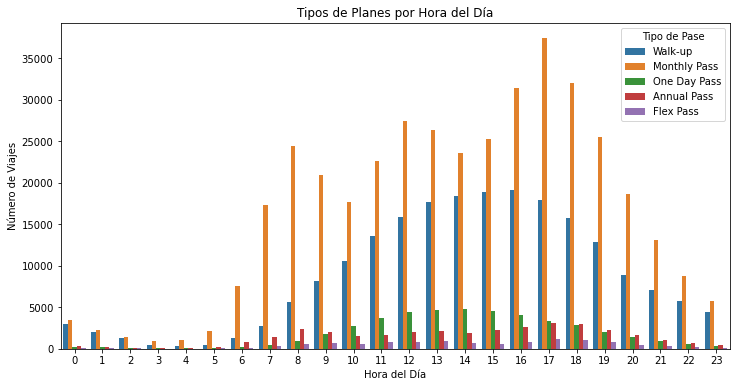

In [25]:
df_train['hour'] = df_train['start_time'].dt.hour

plt.figure(figsize=(12,6))
sns.countplot(x='hour', hue='passholder_type', data=df_train)
plt.title('Tipos de Planes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Viajes')
plt.legend(title='Tipo de Pase')
plt.show()

Se analiza la distribucion de consumo por horario y tipo de pase.
- Los viajes que usan Monthly pass tienen una demanda con picos a las 8hr, medio dia y 17hrs, manteniendo una demanda alta casi todo el día.
- Los demas pases tienen una distribucion normal.

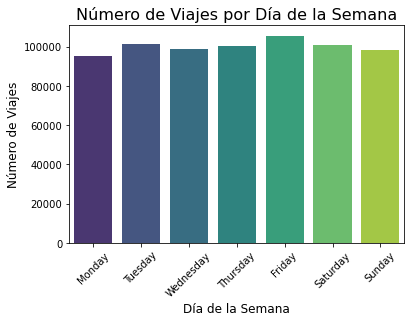

In [26]:
df_train['day_of_week'] = df_train['start_time'].dt.day_name()

demand_by_day = df_train.groupby('day_of_week').size().reset_index(name='num_trips')

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_by_day['day_of_week'] = pd.Categorical(demand_by_day['day_of_week'], categories=ordered_days, ordered=True)


demand_by_day = demand_by_day.sort_values('day_of_week')

sns.barplot(x='day_of_week', y='num_trips', data=demand_by_day, palette='viridis')
plt.title('Número de Viajes por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Número de Viajes', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [27]:
total_trips = demand_by_day['num_trips'].sum()
demand_by_day['percentage'] = (demand_by_day['num_trips'] / total_trips) * 100
mean_percentage = demand_by_day['percentage'].mean()
display(demand_by_day)
print(f"La media de los porcentajes es: {mean_percentage:.2f}%")

,day_of_week,num_trips,percentage
1,Monday,95018,13.575513
5,Tuesday,101361,14.481757
6,Wednesday,98556,14.080998
4,Thursday,100343,14.336312
0,Friday,105558,15.081395
2,Saturday,100635,14.378031
3,Sunday,98451,14.065996


La media de los porcentajes es: 14.29%


Se analiza la cantidad de viajes por día de semana para saber si hay día con mayor o menor demanda.
- En general el consumo por día se manteniene relativamente constante cerca de la media.
- El día viernes es día con mayor demanda con un .7% extra de viajes arriba de la media.
- El día lunes es el día con menor demanda con un .7% menos de la media.

In [28]:
demand_by_station = df_train.groupby('start_station').size().reset_index(name='demand')

kmeans = KMeans(n_clusters=8, random_state=42)

demand_by_station['cluster'] = kmeans.fit_predict(demand_by_station[['demand']])

demand_by_station.head()

,start_station,demand,cluster
0,3000,1128,0
1,3005,28490,3
2,3006,12645,1
3,3007,10774,6
4,3008,9051,6


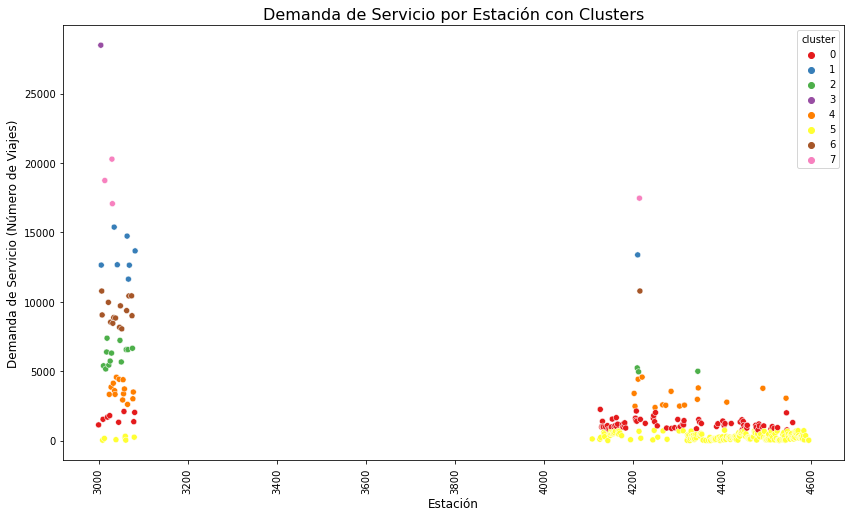

In [29]:
plt.figure(figsize=(14, 8))

sns.scatterplot(data=demand_by_station, x='start_station', y='demand', hue='cluster', palette='Set1')

plt.xticks(rotation=90)

plt.title('Demanda de Servicio por Estación con Clusters', fontsize=16)
plt.xlabel('Estación', fontsize=12)
plt.ylabel('Demanda de Servicio (Número de Viajes)', fontsize=12)

plt.show()

In [30]:
demand_range_by_cluster = demand_by_station.groupby('cluster')['demand'].agg(['min', 'max']).reset_index()
display(demand_range_by_cluster)

,cluster,min,max
0,0,767,2246
1,1,11633,15381
2,2,4954,7377
3,3,28490,28490
4,4,2381,4573
5,5,1,742
6,6,8048,10776
7,7,17069,20280


In [31]:
stations_in_clusters = demand_by_station.groupby('cluster')[['start_station', 'demand']].apply(lambda x: x.sort_values('demand')).reset_index(drop=True)
display(stations_in_clusters)

,start_station,demand
0,4545,767
1,4480,768
2,4147,771
3,4445,792
4,4144,810
...,...,...
359,4215,10776
360,3031,17069
361,4214,17466
362,3014,18739


In [32]:
stations_above_11000 = demand_by_station[demand_by_station['demand'] > 11000]
stations_above_11000 = stations_above_11000.sort_values(by='demand', ascending=False).reset_index()
display(stations_above_11000)

,index,start_station,demand,cluster
0,1,3005,28490,3
1,22,3030,20280,7
2,9,3014,18739,7
3,122,4214,17466,7
4,23,3031,17069,7
5,27,3035,15381,1
6,51,3064,14733,1
7,65,3082,13667,1
8,118,4210,13379,1
9,33,3042,12667,1


In [33]:
top5 = pd.DataFrame()
top5['Station'] = df_train['start_station'].value_counts().head().index
top5['Number of Starts']=df_train['start_station'].value_counts().head().values
top5['Station'] = top5['Station'].astype('category')
top5['Station'] = top5.Station.cat.remove_unused_categories()

C:\Users\cpalomino\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


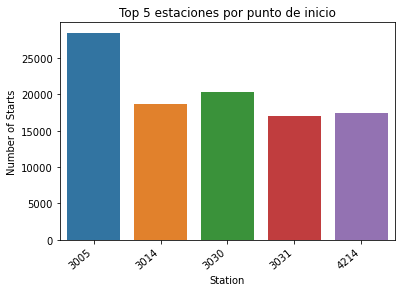

In [34]:
sns.barplot('Station', 'Number of Starts', data = top5)
plt.xticks(rotation=40, ha = 'right')
plt.title("Top 5 estaciones por punto de inicio")
plt.show()

In [35]:
trips = pd.DataFrame()
trips = df_train.groupby(['start_station','end_station']).size().reset_index(name = 'Number of Trips')
trips = trips.sort_values('Number of Trips', ascending = False)
trips['start_station'] = trips['start_station'].astype('str')
trips['end_station'] = trips['end_station'].astype('str')
trips["Trip"] = trips["start_station"] + " to " + trips["end_station"]
trips = trips[:10]
trips = trips.drop(['start_station', "end_station"], axis = 1)
trips = trips.reset_index()


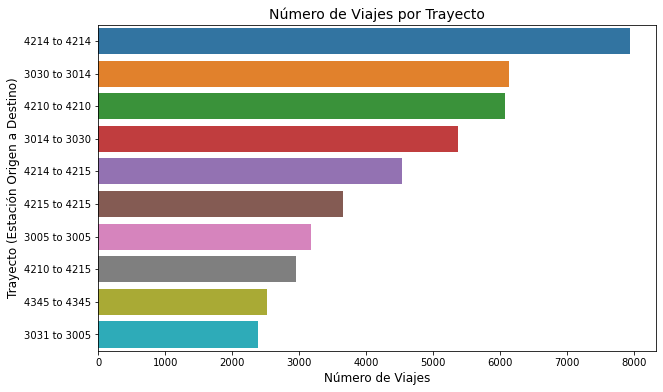

In [36]:
plt.figure(figsize=(10, 6))

sns.barplot(x='Number of Trips', y='Trip', data=trips, orient='h')

plt.title('Número de Viajes por Trayecto', fontsize=14)
plt.xlabel('Número de Viajes', fontsize=12)
plt.ylabel('Trayecto (Estación Origen a Destino)', fontsize=12)

plt.show()

Se agruparon las estaciones en clusters por demanda de viajes.
- Clusters 1,3 y 7 son los que tienen mas viajes.
- Hay 12 estaciones que estan en estos clusters con una demanda superior a los 11mil viajes.
- Estaciones 3005 y 3030 tienen una demanda superior a los 20mil viajes.
- Los viajes One-Way más usados son los de la ruta 3030 -3014 , 3014 -3030 , 4214 -4215 

In [37]:
def plot_trip_route_by_year(df_train, years, columna_fecha='start_time', bins=20):
    """
    Grafica la distribución de tipos de ruta por mes para diferentes años.
    
    Parameters:
    - df_train: DataFrame que contiene los datos.
    - years: Lista de años a graficar.
    - columna_fecha: Nombre de la columna de fecha (por defecto 'start_time').
    """
    df_train['year'] = df_train[columna_fecha].dt.year
    df_train['month'] = df_train[columna_fecha].dt.month
    
    ncols = 2  
    nrows = int(np.ceil(len(years) / ncols))  
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 18))
    
    if len(years) == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()
    
    for i, year in enumerate(years):
        
        df_year = df_train[df_train['year'] == year]
        
        # Asegúrate de que todos los meses estén presentes, incluso si no hay viajes en alguno
        all_months = pd.DataFrame({'month': range(1, 13)})
        monthly_trip_counts = df_year.groupby(['month', 'trip_route_category']).size().reset_index(name='count')
        
        # Unir para asegurarse de que todos los meses estén en los datos
        monthly_trip_counts = pd.merge(all_months, monthly_trip_counts, on='month', how='left').fillna({'count': 0})
        
        # Gráfica con los datos
        sns.histplot(data=monthly_trip_counts, x='month', hue='trip_route_category', weights='count', multiple="stack", kde=False, ax=axes[i],binwidth=1, discrete=True )
        
        axes[i].set_title(f'Distribución de Tipos de Ruta por Mes en {year}', fontsize=16)
        axes[i].set_xlabel('Mes del Año', fontsize=12)
        axes[i].set_ylabel('Número de Viajes', fontsize=12)
        axes[i].set_xticks(range(1, 13))
        axes[i].set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    
    plt.tight_layout()
    plt.show()

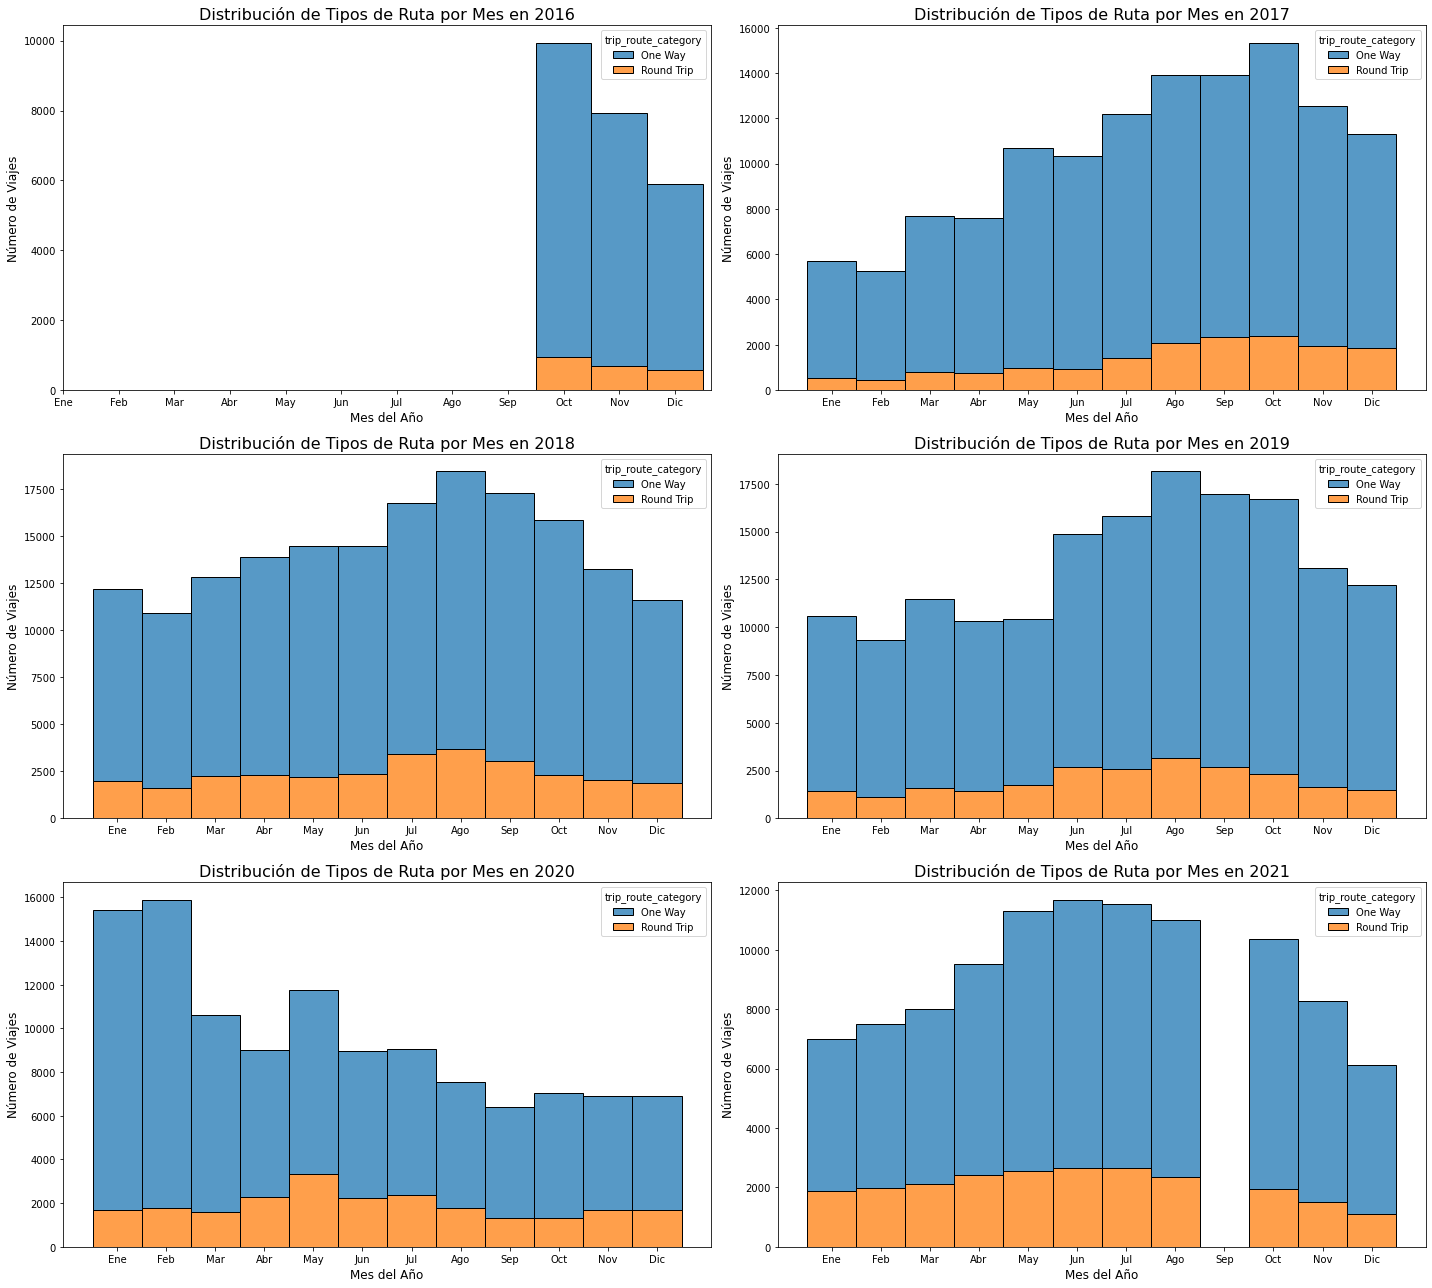

In [38]:
plot_trip_route_by_year(df_train, years=[2016, 2017, 2018, 2019 ,2020, 2021],bins = 12)

In [39]:
monthly_trip_counts = df_train.groupby('month').size()

mean_trips_per_month = monthly_trip_counts.mean()


total_trips = monthly_trip_counts.sum()

monthly_percentage = (monthly_trip_counts / total_trips) * 100
monthly_trips = pd.DataFrame({
    'total_trips': monthly_trip_counts,
    'percentage': monthly_percentage
})


print(f"Media de viajes por mes: {mean_trips_per_month}")
print(monthly_trips)

Media de viajes por mes: 58326.833333333336
       total_trips  percentage
month                         
1            50876    7.268810
2            48861    6.980921
3            50566    7.224519
4            50319    7.189230
5            58653    8.379934
6            60346    8.621818
7            65347    9.336326
8            69054    9.865956
9            54593    7.799869
10           75281   10.755627
11           62004    8.858701
12           54022    7.718289


Se revisa la tendencia historica por año del uso de tipo de viajes (One-way y Round Trip)
- Historicamente el Round Trip aunque es menor menor mantiene la misma curca que One-Way.
- La tendencia del uso  tiene una liger alza en verano durante los meses de jun a agosto y octubre con el mes con la mayor demanda, estando por encima de la media.

## Resumen 

Saturación del servicio:

__Horario__
- Se concluye que la hora pico de demanda son las 17hr, manteniendo un alto consumo durante las horas de 12 a 18hrs
- Se suele tener un consumo superior de 10 mil viajes por hora durante las horas pico
- El día viernes tiene un 0.7% más demanda a comparación de la media de los demás días, menos el lunes que tiene un 0.7% menos que la media.

__Planes__
- 56.7% son viajes hechos con Monthly Pass
- 4.8% son viajes hechos con Annual Pass 

__Tipos de Viaje__
- 83.2% de los viajes son One-way
- En todos los planes la mayoría de tipos de viaje son One-way

__Estaciones__
- 12 Estaciones con una demanda superior a los 11 mil viajes (3005 ,3030,3014,4214,3031,3035,3064,3082,4210,3042,3006,3069,3067)
- Estaciones 3005 y 3030 con demanda superior a 20 mil viajes
- Los viajes One-Way más usados son los de la ruta 3030 -3014 , 3014 -3030 , 4214 -4215 

__Estacionalidad__
- Incremento de la demanda en los meses de Jun a Nov, con un pico en Octubre de 2.5% sobre la media.



## Conclusion
- Se recomienda aumentar la disponibilidad de bicicletas durante las horas de 12 a 18 hrs, sobre todo los días viernes.
- No se ve ninguna tendencia para preveer que el Annual Pass vaya a tener un mayor consumo por loque se recomienda hacer algún tipo de campaña para promocionarlo.
- Se confirma que los One-Way trips son los mas usados, por lo que se debe hacer una buena logistica para re-acomodar las bicicletas en sus estaciones correspondientes
- Se deben asignar más bicicletas a las estaciones (3005 ,3030,3014,4214,3031,3035,3064,3082,4210,3042,3006,3069,3067), sobre todo a la 3005 y 3030, ya que son las que más demanda tienen.
- Ya que las rutas de un solo viaje son las 3030 -3014 , 3014 -3030 , 4214 -4215 , se recomienda hacer un balanceo en horas picos para contar con suficientes bicicletas en esas rutas.


## Modelo Analítico

Se desea saber si es posible inferir el tipo de pase tomando en cuentas las variables de viaje. 

Ya que la variable objetivo para predecir el tipo de viaje es el "passholder_type" y esta es una variable categórica,  nos enfrentamos a un problema de __clasificación__, por lo que se seleccionara un modelo supervisado de clasificación.

Para la construccion y entrenamiento del Modelo de prediccion del tipo de pase se realizaran las siguientes tareas:

* Importacion del conjunto de datos para su entrenamiento y validacion (hecho en el primer segmento)
* Segmentacion de datos para su entreamiento, validacion y prueba (los conjuntos de datos ya venian segmentados)
* Creacion de Modelo con un valor minimo de 0.59 F1
* Verificación de F1 para el conjunto de prueba.
* Medición de la métrica AUC-ROC 
* Comparación AUC-ROC vs F1
* Conclusion final


In [40]:
df_train = df_train.drop(["end_time"], axis = 1)
df_test = df_test.drop(["end_time"], axis = 1)


In [41]:
df_test['start_time'] = pd.to_datetime(df_test['start_time'])
df_train["day_of_week"] = df_train["start_time"].dt.day

df_test["hour"] = df_test["start_time"].dt.hour
df_test["day_of_week"] = df_test["start_time"].dt.day
df_test["year"] = df_test["start_time"].dt.year
df_test["month"] = df_test["start_time"].dt.month



In [42]:
df_train = df_train.drop(["start_time"], axis = 1)
df_test = df_test.drop(["start_time"], axis = 1)

In [43]:
display(df_train.head())
display(df_train.info())

,trip_id,duration,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,hour,day_of_week,year,month
0,101750280,35,06530,1.0,Round Trip,Walk-up,4127,4127,11,7,2018,8
1,46560345,32,6683,0.0,One Way,Walk-up,3057,3062,17,17,2017,9
2,120016336,6,06710,30.0,One Way,Monthly Pass,3022,3062,9,22,2019,4
3,129547190,138,17068,1.0,One Way,One Day Pass,4304,4311,11,22,2019,9
4,136619463,14,18841,30.0,One Way,Monthly Pass,4266,4443,17,31,2020,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 699922 entries, 0 to 699999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              699922 non-null  int64  
 1   duration             699922 non-null  int64  
 2   bike_id              699922 non-null  object 
 3   plan_duration        699922 non-null  float64
 4   trip_route_category  699922 non-null  object 
 5   passholder_type      699922 non-null  object 
 6   start_station        699922 non-null  int64  
 7   end_station          699922 non-null  int64  
 8   hour                 699922 non-null  int64  
 9   day_of_week          699922 non-null  int64  
 10  year                 699922 non-null  int64  
 11  month                699922 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 69.4+ MB


None

In [44]:
display(df_test.head())
display(df_test.info())

,trip_id,duration,bike_id,trip_route_category,start_station,end_station,hour,day_of_week,year,month
0,17059130,12,6351,Round Trip,3028,3028,0,1,2017,1
1,17059129,17,5836,One Way,3027,3018,0,1,2017,1
2,17059126,20,6529,One Way,3066,3055,0,1,2017,1
3,17059125,12,6029,One Way,3029,3079,0,1,2017,1
4,17061379,48,6680,Round Trip,3063,3063,0,1,2017,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569886 entries, 0 to 569885
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   trip_id              569886 non-null  int64 
 1   duration             569886 non-null  int64 
 2   bike_id              569886 non-null  object
 3   trip_route_category  569886 non-null  object
 4   start_station        569886 non-null  int64 
 5   end_station          569886 non-null  int64 
 6   hour                 569886 non-null  int64 
 7   day_of_week          569886 non-null  int64 
 8   year                 569886 non-null  int64 
 9   month                569886 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 43.5+ MB


None

Se hace un match de las caracteristicas del conjunto de test y de train, y se desglosa start_time en hora, dia, mes y año, ademas se usa el metodo OHE para convertir trip_route_category de categorica a binaria.

In [45]:
#Codifico numericamente passholder_type
le = LabelEncoder()
df_train['passholder_type'] = le.fit_transform(df_train['passholder_type'])


In [46]:
# One-Hot Encoding de las columnas categóricas
df_train = pd.get_dummies(df_train, columns=['trip_route_category', 'start_station', 'end_station'])

In [47]:
df_train = df_train.drop(["bike_id"], axis = 1)
df_test = df_test.drop(["bike_id"], axis = 1)

Se han codificado las caracteristicas y objetivos categoricos, para poderlos procesar en el modelo

In [48]:
display(df_train)

,trip_id,duration,plan_duration,passholder_type,hour,day_of_week,year,month,trip_route_category_One Way,trip_route_category_Round Trip,...,end_station_4578,end_station_4579,end_station_4580,end_station_4581,end_station_4582,end_station_4583,end_station_4584,end_station_4587,end_station_4593,end_station_4594
0,101750280,35,1.0,4,11,7,2018,8,0,1,...,0,0,0,0,0,0,0,0,0,0
1,46560345,32,0.0,4,17,17,2017,9,1,0,...,0,0,0,0,0,0,0,0,0,0
2,120016336,6,30.0,2,9,22,2019,4,1,0,...,0,0,0,0,0,0,0,0,0,0
3,129547190,138,1.0,3,11,22,2019,9,1,0,...,0,0,0,0,0,0,0,0,0,0
4,136619463,14,30.0,2,17,31,2020,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,83666862,17,30.0,2,18,25,2018,4,1,0,...,0,0,0,0,0,0,0,0,0,0
699996,132547303,9,30.0,2,16,12,2019,11,1,0,...,0,0,0,0,0,0,0,0,0,0
699997,67332628,6,365.0,1,15,13,2018,1,1,0,...,0,0,0,0,0,0,0,0,0,0
699998,114846232,3,1.0,4,14,4,2019,2,1,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_train = df_train.drop(columns=['passholder_type', 'trip_id']) 
y_train = df_train['passholder_type'] 

In [50]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [51]:
print(X_train_split.dtypes)
print(X_val_split.dtypes)
print(y_train_split.dtypes)
print(y_val_split.dtypes)

duration              int64
plan_duration       float64
hour                  int64
day_of_week           int64
year                  int64
                     ...   
end_station_4583      uint8
end_station_4584      uint8
end_station_4587      uint8
end_station_4593      uint8
end_station_4594      uint8
Length: 741, dtype: object
duration              int64
plan_duration       float64
hour                  int64
day_of_week           int64
year                  int64
                     ...   
end_station_4583      uint8
end_station_4584      uint8
end_station_4587      uint8
end_station_4593      uint8
end_station_4594      uint8
Length: 741, dtype: object
int32
int32


In [52]:
# Inicializar el modelo Random Forest
rf = RandomForestClassifier(class_weight= "balanced",random_state=12345,n_estimators = 40, max_depth = 8)

# Entrenar el modelo
rf.fit(X_train_split, y_train_split)

# Predecir sobre el conjunto de validación
y_pred = rf.predict(X_val_split)

# Evaluar el modelo
print(classification_report(y_val_split, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      6816
           1       0.81      0.98      0.89      2330
           2       0.87      0.91      0.89     79739
           3       0.24      0.69      0.36      8871
           4       0.84      0.40      0.54     42229

    accuracy                           0.75    139985
   macro avg       0.72      0.79      0.71    139985
weighted avg       0.82      0.75      0.75    139985



Se eligio el modelo de RandomForest y se analizo cuales son los mejores hiperparametros resultando en un n_est = 40 y profundidad de 8
Se corrio el classification report para ver la precision y exactitud del modelo.

__Para la clase__ 
* 0 Annual Pass : El modelo tiene un muy buen balance entre precision y recall de 0.89
* 1 Flex Pass : El modelo tiene un muy buen balance entre precision y recall de 0.89
* 2 Monthly Pass : El modelo tiene un muy buen balance entre precision y recall de 0.89
* 3 One Day Pass: El modelo tiene un  balance entre precision y recall de 0.36
* 4 Walk-up : El modelo tiene un  balance entre precision y recall de 0.54

Se puede notar que para el Annual Pass, Flex Pass y Monthly Pass tiene mejor balance en su precision y recall, que el One Day y el Walk-Up que le cuesta mas tranajo al modelo predecirlos.

In [53]:
df_test = pd.get_dummies(df_test, columns=['trip_route_category', 'start_station', 'end_station'])
X_test = df_test.drop(columns=['trip_id'])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [54]:
y_test_pred = rf.predict(X_test)

y_test_pred_original = le.inverse_transform(y_test_pred)

df_test['passholder_type'] = y_test_pred_original

df_test.head()

,trip_id,duration,hour,day_of_week,year,month,trip_route_category_One Way,trip_route_category_Round Trip,start_station_3000,start_station_3005,...,end_station_4580,end_station_4581,end_station_4582,end_station_4583,end_station_4584,end_station_4587,end_station_4592,end_station_4593,end_station_4594,passholder_type
0,17059130,12,0,1,2017,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Walk-up
1,17059129,17,0,1,2017,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Monthly Pass
2,17059126,20,0,1,2017,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Monthly Pass
3,17059125,12,0,1,2017,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Monthly Pass
4,17061379,48,0,1,2017,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Walk-up


In [55]:
df_test[['trip_id', 'passholder_type']].to_csv('predictions_2.csv', index=False)

## Conclusion

* Si se puede hacer un modelo para predecir el tipo de de pase para los trip_ids
* Las características que pueden impactar más son el tipo de ruta junto con la estacion de inicio y finalizacion, así como las horas.
* Debido a que la mayoría de los datos son de Monthly Pass, se encuentra un desbalance de los demas tipos de pases, por lo que se tuvo que agregar un weight_class para intentar balancearlo, pero para seguir mejorando el modelo se puede optar por otras alternativas como aumentar el sample , o intentar otro tipo de modelo como Gradient Boosting, XGBoost, o LightGBM.
* En general mi percepción es que es un modelo un poco pobre debido a las características con las que cuenta. Yo añadiria un __user_id__, para identificar todos los viajes de ese usuario  y poder ver cuantos usuarios reales hay por pase. Además de estandarizar el plan duration  para que coincida con el passholder_type. También se podrían agregar caracteristicas de __distancia__ entre estaciones. Así como saber si la estación se encuentra cerca de zonas turisticas para mejorar la predicción de bicicletas a abastecer por estación. Por otro lado teniendo el user_id se podría identificar la __frecuencia__ de uso del usario, para ver si realmente hacen un buen uso del pase, asi como el __precio__ de cada pase, para entender el porque la mayoria prefiere un pase mensual y por último la edad del usuario , para poder correlacionar el usuario cn la frecuencia y el tipo de pase. 
* Estas características extrar ayudarían a entender mejor al tipo de usuario, su uso y poder hacer campañas de marketing para aumentar el consumo de X plan.

## Preparación de conjunto de datos para Modelos

### Modelo de Regresion Logistica

## Diagrama de flujo 
Diagrama de flujo de un modelo de clasificación multiclase desde el entrenamiento hasta la puesta en producción
Recopilación de Datos

__Fuente de datos:__ Bases de datos, archivos CSV, APIs, etc.
- Extracción/Recopilación: Se recopilan los datos relevantes para el modelo, que incluyen las características necesarias para la clasificación 

__Preprocesamiento de Datos__

- Limpiar Datos: Manejo de valores faltantes, corrección de datos inconsistentes.
- Transformaciones: Escalado de características, conversión de variables categóricas a variables numéricas, normalización, etc.
- División de Datos: Separar los datos en conjuntos de entrenamiento, validación y prueba.

__Entrenamiento del Modelo__

- Selección del Algoritmo: Selección del modelo de clasificación 
- Entrenamiento: Ajustar el modelo con los hiperparametros adecuados
- Evaluación del Modelo: Evaluar el rendimiento utilizando métricas adecuadas (precisión, recall, F1, matriz de confusión, etc.) en el conjunto de validación.

__Evaluación Final__

- Prueba: Evaluar el modelo final en el conjunto de prueba para obtener una estimación de su rendimiento real.
- Análisis de Resultados: Revisar métricas de rendimiento y determinar si el modelo está listo para producción.

__Puesta en Producción__

- Despliegue del Modelo:
  Contenedorización: Empacar el modelo en un contenedor para facilitar el despliegue.
- Despliegue en Servidor: El modelo se coloca en un servidor para que pueda hacer predicciones en tiempo real o por lotes.
- APIs de Predicción: Se puede exponer el modelo a través de una API RESTful para interactuar con aplicaciones externas para su consumo
- Monitorización: Implementar monitoreo del rendimiento del modelo en producción, para detectar posibles caídas de rendimiento con el tiempo.
- Retraining: Programar un ciclo de retraining como parte de mantenimiento preventivo para evitar decrecimiento en el rendimiento debido a cambios en los datos de entrada.

__Uso del Modelo en Producción__

- Predicciones en Tiempo Real: El modelo se utiliza para hacer predicciones sobre los datos entrantes en tiempo real.